## Spam Email Classifier with KNN using TF-IDF scores

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   The report file must be a well documented jupyter notebook, explaining the experiments you have performed, evaluation metrics and corresponding code. The code must run and be able to reproduce the accuracies, figures/graphs etc.
5.   For all the questions, you must create a train-validation data split and test the hyperparameter tuning on the validation set. Your jupyter notebook must reflect the same.
6.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

**Task: Given an email, classify it as spam or ham**

Given input text file ("emails.txt") containing 5572 email messages, with each row having its corresponding label (spam/ham) attached to it.

This task also requires basic pre-processing of text (like removing stopwords, stemming/lemmatizing, replacing email_address with 'email-tag', etc..).

You are required to find the tf-idf scores for the given data and use them to perform KNN using Cosine Similarity.

### Import necessary libraries

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import numpy as np
import math
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.neighbors import NearestNeighbors

### Load dataset

In [2]:
with open('emails.txt', 'r') as inFile:
    email_data = inFile.readlines()

In [3]:
test_train_ratio = 0.2

### Preprocess data

In [4]:
word_list = list()
is_spam = list()
stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
vocabulary = dict()

In [5]:
for i, email in enumerate(email_data):
    email_data[i] = re.sub(r"[^a-zA-Z0-9]", " ", email.lower())
    word_list.append(email_data[i].split())
    if word_list[i][0] == 'spam':
        is_spam.append(True)
    else:
        is_spam.append(False)
    word_list[i].pop(0)

In [6]:
cnt = 0
for i, email in enumerate(word_list):
    temp_sentence = list()
    for word in word_list[i]:
        if word not in stopwords:
            temp_word = lemmatizer.lemmatize(word)
            temp_sentence.append(temp_word)
            if temp_word not in vocabulary:
                vocabulary[temp_word] = cnt
                cnt += 1
    word_list[i] = temp_sentence

In [7]:
vocabulary_count = len(vocabulary)
email_count = len(word_list)
tf = np.zeros((vocabulary_count, email_count))
idf = np.zeros((vocabulary_count))
tf_idf = np.zeros((email_count, vocabulary_count))
for i, email in enumerate (word_list):
    for j, word in enumerate (word_list[i]):
        tf[vocabulary[word]][i] += 1
    for j, word in enumerate (word_list[i]):
        tf[vocabulary[word]][i] /= len(word_list[i])
    

In [8]:
for i in range(vocabulary_count):
    for j in range(email_count):
        if tf[i][j] > 0:
            idf[i] += 1
for i in range(vocabulary_count):
    temp_idf = math.log((email_count) / (idf[i]))
    idf[i] = temp_idf

In [9]:
for i in range(vocabulary_count):
    for j in range(email_count):
        tf_idf[j][i] = tf[i][j] * idf[i]

### Split data

In [10]:
tf_idf_train, tf_idf_test, is_spam_train, is_spam_test = train_test_split(tf_idf, is_spam, test_size = test_train_ratio, random_state = None)

### Train your KNN model (reuse previously implemented model built from scratch) and test on your data

***1. Experiment with different distance measures [Euclidean distance, Manhattan distance, Hamming Distance] and compare with the Cosine Similarity distance results.***

In [11]:
def KNN(v1, function_involved, k_value):
    neighbors = dict()
    for i,vec in enumerate(tf_idf_train):
        neighbors[i] = function_involved(v1, vec)
    sort_by_value = dict(sorted(neighbors.items(), key=lambda item: item[1]))
    return list(sort_by_value.keys())[:k_value]

# def KNN(v1, function_involved, k_value):
#     neighbors = np.zeros(len(tf_idf_train))
#     for i,vec in enumerate(tf_idf_train):
#         neighbors[i] = function_involved(v1, vec)

    return np.argsort(neighbors)[:k_value]

def cosine(v1, v2):
    if (np.linalg.norm(v1)*np.linalg.norm(v2)) == 0:
        return 0
    else :
        return -np.sum(v1*v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

def euclidean(v1, v2) :
    return np.sqrt(np.sum((v1-v2)*(v1-v2)))

def manhattan(v1, v2) :
    return np.sum(np.abs(v1-v2))

def predict(neighbors):
    spam_cnt = 0
    ham_cnt = 0
    for vec in neighbors:
        if is_spam_train[vec] == True:
            spam_cnt += 1
        else:
            ham_cnt += 1
    if spam_cnt > ham_cnt:
        return True
    else:
        return False

def print_table(heading, percentage, precision,recall, f1, true_positive, false_positive, false_negative, true_negative):
    print(f'Method Used: {heading}')
    print(f'Percentage accuracy with euclidean similarity : {percentage}')
    print(f'Precision : {precision}')
    print(f'Recall : {recall}')
    print(f'F1 Score : {f1}')

    print('Confusion matrix is given below :')

    print(f'\t \t \t Actual positive \t Actual negative')
    print(f'Predicted positive \t {true_positive} \t \t \t {false_positive}')
    print(f'Predicted negative \t {false_negative} \t \t \t {true_negative}')

def get_stats(heading, true_positive, false_positive, true_negative, false_negative, length, percentage):
    precision = true_positive/(true_positive+false_positive)
    recall = true_positive/(true_positive+false_negative)
    f1 = 2*((precision*recall)/(precision+recall))
    percentage_method = (percentage/length)*100
    print_table(heading, percentage_method, precision, recall, f1, true_positive, false_positive, false_negative, true_negative)

def initiate_calc(predictionlist, heading):
    percentage = 0
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for i in range(len(predictionlist)) :
        if is_spam_test[i] == True and predictionlist[i] == is_spam_test[i]:
            true_positive += 1
        if is_spam_test[i] == False and predictionlist[i] == is_spam_test[i]:
            true_negative += 1
        if predictionlist[i] == True and predictionlist[i] != is_spam_test[i]:
            false_positive += 1
        if predictionlist[i] == False and predictionlist[i] != is_spam_test[i]:
            false_negative += 1
        if predictionlist[i] == is_spam_test[i]:
            percentage += 1
    get_stats(heading, true_positive, false_positive, true_negative, false_negative, len(predictionlist), percentage)

In [12]:
predictionlist_cosine = list()
predictionlist_euclidean = list()
predictionlist_manhattan = list()
f1_cosine = list()
f1_euclidean = list()
f1_manhattan = list()

***Euclidean Distance***

In [13]:
predictionlist_euclidean = []
for i,vec in enumerate(tf_idf_test):
    neighbors = list()
    neighbors = KNN(vec, euclidean, 9)
    predictionlist_euclidean.append(predict(neighbors))
    heading = "Euclidean"
initiate_calc(predictionlist_euclidean, heading)
    

Method Used: Euclidean
Percentage accuracy with euclidean similarity : 87.89237668161435
Precision : 0.9230769230769231
Recall : 0.0821917808219178
F1 Score : 0.1509433962264151
Confusion matrix is given below :
	 	 	 Actual positive 	 Actual negative
Predicted positive 	 12 	 	 	 1
Predicted negative 	 134 	 	 	 968


***Cosine Similarity***

In [14]:
predictionlist_cosine = []
for i,vec in enumerate(tf_idf_test):
    neighbors = list()
    neighbors = KNN(vec, cosine, 9)
    predictionlist_cosine.append(predict(neighbors))
    heading = "Cosine"
initiate_calc(predictionlist_cosine, heading)

Method Used: Cosine
Percentage accuracy with euclidean similarity : 95.69506726457399
Precision : 1.0
Recall : 0.6712328767123288
F1 Score : 0.8032786885245902
Confusion matrix is given below :
	 	 	 Actual positive 	 Actual negative
Predicted positive 	 98 	 	 	 0
Predicted negative 	 48 	 	 	 969


***Manhattan Distance***

In [15]:
predictionlist_manhattan = []
for i,vec in enumerate(tf_idf_test):
    neighbors = list()
    neighbors = KNN(vec, manhattan, 21)
    predictionlist_manhattan.append(predict(neighbors))
    heading = "Manhattan"
initiate_calc(predictionlist_manhattan, heading)
    

Method Used: Manhattan
Percentage accuracy with euclidean similarity : 87.98206278026906
Precision : 1.0
Recall : 0.0821917808219178
F1 Score : 0.1518987341772152
Confusion matrix is given below :
	 	 	 Actual positive 	 Actual negative
Predicted positive 	 12 	 	 	 0
Predicted negative 	 134 	 	 	 969


***2. Explain which distance measure works best and why? Explore the distance measures and weigh their pro and cons in different application settings.***

Cosine similarity should work better in theory as it involves computing the angle between two vectors to measure the distance between them rather than the other two that depend on the vectors' magnitudes.

***3. Report Mean Squared Error(MSE), Mean-Absolute-Error(MAE), R-squared (R2) score in a tabular form***

|  | Cosine similarity | Euclidean distance | Manhattan distance |
| --- | --- | --- | --- |
| Accuracy | 95.69506726457399 | 87.89237668161435 | 87.98206278026906 |
| Precision | 1.0 | 0.9230769230769231 | 1.0|
| Recall | 0.6712328767123288 | 0.0821917808219178 | 0.0821917808219178 |
| F1 Score | 0.8032786885245902 | 0.1509433962264151 | 0.1518987341772152 |

***4. Choose different K values (k=1,3,5,7,11,17,23,28) and experiment. Plot a graph showing R2 score vs k.***

In [16]:
k = np.array([1, 3, 5, 7, 11, 17, 23, 28])

***Euclidean distance***

In [17]:
f1_euclidean = []
for i, temp_k in enumerate(k):
    predictionlist_euclidean = []
    for i,vec in enumerate(tf_idf_test):
        neighbors = list()
        neighbors = KNN(vec, euclidean, temp_k)
        predictionlist_euclidean.append(predict(neighbors))
        heading = "Euclidean"
    percentage = 0
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for i in range(len(predictionlist_euclidean)) :
        if is_spam_test[i] == True and predictionlist_euclidean[i] == is_spam_test[i]:
            true_positive += 1
        if is_spam_test[i] == False and predictionlist_euclidean[i] == is_spam_test[i]:
            true_negative += 1
        if predictionlist_euclidean[i] == True and predictionlist_euclidean[i] != is_spam_test[i]:
            false_positive += 1
        if predictionlist_euclidean[i] == False and predictionlist_euclidean[i] != is_spam_test[i]:
            false_negative += 1
        if predictionlist_euclidean[i] == is_spam_test[i]:
            percentage += 1
    precision = true_positive/(true_positive+false_positive)
    recall = true_positive/(true_positive+false_negative)
    f1 = 2*((precision*recall)/(precision+recall))
    f1_euclidean.append(f1)

f1_euclidean

[0.6964285714285715,
 0.54,
 0.43010752688172044,
 0.33142857142857146,
 0.2619047619047619,
 0.19753086419753085,
 0.1282051282051282,
 0.05333333333333332]

Text(0, 0.5, 'F1 Scores')

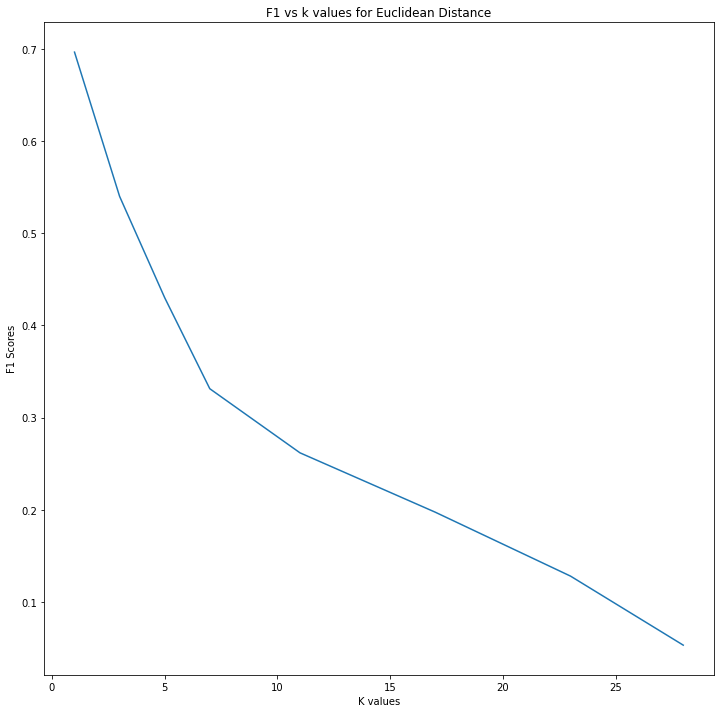

In [18]:
plt.figure(figsize=[12, 12])
plt.plot(k, f1_euclidean)
plt.title('F1 vs k values for Euclidean Distance')
plt.xlabel('K values')
plt.ylabel('F1 Scores')

***Cosine Similarity***

In [22]:
f1_cosine = []
for i, temp_k in enumerate(k):
    predictionlist_cosine = []
    for i,vec in enumerate(tf_idf_test):
        neighbors = list()
        neighbors = KNN(vec, cosine, temp_k)
        predictionlist_cosine.append(predict(neighbors))
        heading = "Cosine"
    percentage = 0
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for i in range(len(predictionlist_cosine)) :
        if is_spam_test[i] == True and predictionlist_cosine[i] == is_spam_test[i]:
            true_positive += 1
        if is_spam_test[i] == False and predictionlist_cosine[i] == is_spam_test[i]:
            true_negative += 1
        if predictionlist_cosine[i] == True and predictionlist_cosine[i] != is_spam_test[i]:
            false_positive += 1
        if predictionlist_cosine[i] == False and predictionlist_cosine[i] != is_spam_test[i]:
            false_negative += 1
        if predictionlist_cosine[i] == is_spam_test[i]:
            percentage += 1
    precision = true_positive/(true_positive+false_positive)
    recall = true_positive/(true_positive+false_negative)
    f1 = 2*((precision*recall)/(precision+recall))
    f1_cosine.append(f1)

f1_cosine

KeyboardInterrupt: 

Text(0, 0.5, 'F1 Scores')

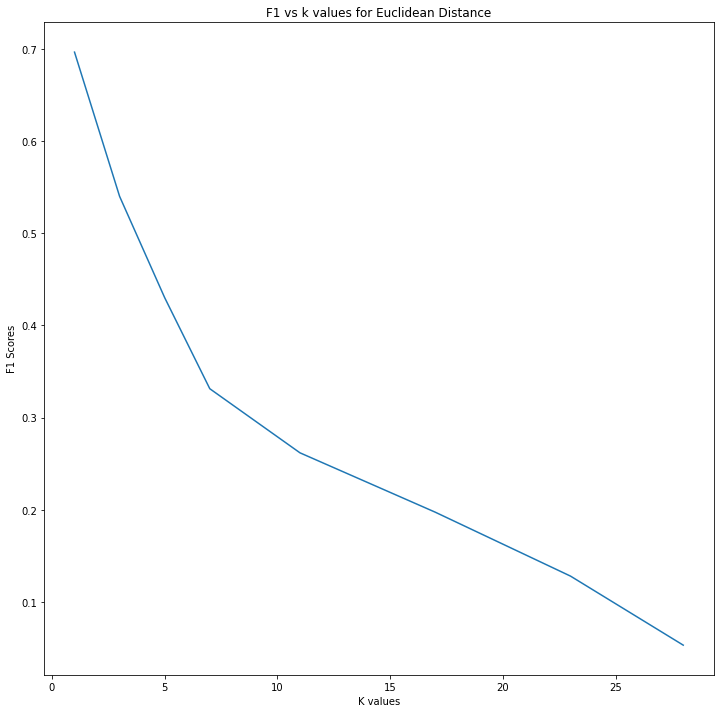

In [ ]:
plt.figure(figsize=[12, 12])
plt.plot(k, f1_cosine)
plt.title('F1 vs k values for Cosine similarity')
plt.xlabel('K values')
plt.ylabel('F1 Scores')

***Manhattan Distance***

In [ ]:
f1_manhattan = []
for i, temp_k in enumerate(k):
    predictionlist_manhattan = []
    for i,vec in enumerate(tf_idf_test):
        neighbors = list()
        neighbors = KNN(vec, manhattan, temp_k)
        predictionlist_manhattan.append(predict(neighbors))
        heading = "manhattan"
    percentage = 0
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for i in range(len(predictionlist_manhattan)) :
        if is_spam_test[i] == True and predictionlist_manhattan[i] == is_spam_test[i]:
            true_positive += 1
        if is_spam_test[i] == False and predictionlist_manhattan[i] == is_spam_test[i]:
            true_negative += 1
        if predictionlist_manhattan[i] == True and predictionlist_manhattan[i] != is_spam_test[i]:
            false_positive += 1
        if predictionlist_manhattan[i] == False and predictionlist_manhattan[i] != is_spam_test[i]:
            false_negative += 1
        if predictionlist_manhattan[i] == is_spam_test[i]:
            percentage += 1
    precision = true_positive/(true_positive+false_positive)
    recall = true_positive/(true_positive+false_negative)
    f1 = 2*((precision*recall)/(precision+recall))
    f1_manhattan.append(f1)

f1_manhattan

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=[12, 12])
plt.plot(k, f1_manhattan)
plt.title('F1 vs k values for Manhattan Distance')
plt.xlabel('K values')
plt.ylabel('F1 Scores')

### Train and test Sklearn's KNN classifier model on your data (use metric which gave best results on your experimentation with built-from-scratch model.)

***Euclidean Distance***

In [ ]:
predictionlist_euclidean = []
knn_sklearn = NearestNeighbors(n_neighbors=9, algorithm='auto',metric='euclidean')

knn_sklearn.fit(tf_idf_train)

useless, neighbors = knn_sklearn.kneighbors(tf_idf_test)

for i,neighbors_list in enumerate(neighbors):
    predictionlist_euclidean.append(predict(neighbors_list))
    heading = "Euclidean"
initiate_calc(predictionlist_euclidean, heading)

***Cosine Similarity***

In [ ]:
predictionlist_cosine = []
knn_sklearn = NearestNeighbors(n_neighbors=9, algorithm='auto',metric='cosine')

knn_sklearn.fit(tf_idf_train)

useless, neighbors = knn_sklearn.kneighbors(tf_idf_test)

for i,neighbors_list in enumerate(neighbors):
    predictionlist_cosine.append(predict(neighbors_list))
    heading = "Cosine"
initiate_calc(predictionlist_cosine, heading)

***Manhattan distance***

In [ ]:
predictionlist_manhattan = []
knn_sklearn = NearestNeighbors(n_neighbors=9, algorithm='auto',metric='manhattan')

knn_sklearn.fit(tf_idf_train)

useless, neighbors = knn_sklearn.kneighbors(tf_idf_test)

for i,neighbors_list in enumerate(neighbors):
    predictionlist_manhattan.append(predict(neighbors_list))
    heading = "Manhattan"
initiate_calc(predictionlist_manhattan, heading)

***Compare both the models result.***

***What is the time complexity of training using KNN classifier?***

Training time complexity is O(1)

***What is the time complexity while testing? Is KNN a linear classifier or can it learn any boundary?***

Testing has a time complexity of O(NlogN) as sorting is involved